In [339]:
import keras
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, Dropout, MaxPooling2D
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
import keras.metrics as metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import numpy as np
from PIL import Image
import glob
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#get image file names
file_glob = glob.glob('Fixed_Images/*.jpg')

In [3]:
data = pd.read_csv('dataset.csv') 
df = data.copy()

In [4]:
#drop duplicates found in WVHTft with nan
df.drop_duplicates(['GSTkts', 'WDIR', 'WSPDkts', 'time_stamp'], keep='first', inplace = True)

In [5]:
df.sort_values(by = 'time_stamp', inplace = True)

In [6]:
df = df.reset_index(drop = True)

In [7]:
df.time_stamp = pd.to_datetime(df.time_stamp)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8980 entries, 0 to 8979
Data columns (total 5 columns):
GSTkts        8980 non-null float64
WDIR          8980 non-null object
WSPDkts       8980 non-null float64
WVHTft        1479 non-null float64
time_stamp    8980 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 350.9+ KB


In [9]:
#takes in string name of image file, returns datetime object offset to match image time
def get_time_stamp(name):
    p = 0
    img_date = name.split('_')[2:4]
    img_edt = int(name.split('_')[-1:][0].split('.')[0])
    img_edt = str(img_edt).zfill(4) 
    img_edt = list(img_edt)
    img_edt[-2:] = ['4', '0'] #change all to 40min
    img_edt = ''.join(img_edt)
    img_edt = str(img_edt)
    date = '{}-{}-{} {}' .format('2020', img_date[0], img_date[1], img_edt)
    date = pd.to_datetime(date)
    return date

In [436]:
mn = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [437]:
model = Sequential()
model.add(TimeDistributed(mn, input_shape=(6, 224, 224, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Flatten()))

In [247]:
num_targets = 500

#input string img_path, returns tensors list from 6 image slices, and int target
def get_tensors_and_targets(file_names):
    targets = []
    tensor_stack = []
    for f in file_names:
        img_time = get_time_stamp(f)
        target = df.query('time_stamp == @img_time')['WVHTft'] #gets wvht from match in database
        if len(target) == 0:
            print(img_paths)
        else:
            targets.append(target.values[0])
        img = image.load_img(f, target_size=(260, 1344))
        img_arr = np.array(img)
        list_of_tensors = []
        for i in range(0,6):
            slice_show = i
            slice_size = 1344/6
            img_slice = img_arr[:224, slice_size * slice_show:slice_size * (slice_show + 1), :]
            list_of_tensors.append(np.expand_dims(img_slice, axis=0).astype('float32')/255)
        tensor_stack.append(np.vstack(list_of_tensors))
    return tensor_stack, targets

tensor_stack, targets = get_tensors_and_targets(file_glob[:-1])

In [345]:
predictions = []
for t in tensor_stack:
    t = np.array(t).reshape(1, 6, 224, 224, 3)
    preds = model.predict(t)
    predictions.append(preds)

In [346]:
output_size = 1024

In [347]:
x_train = np.array(predictions[:num_targets]).reshape(num_targets, 6, output_size)
x_test = np.array(predictions[num_targets:]).reshape((len(targets) - num_targets), 6, output_size)

In [349]:
#check for inf or nan
np.isfinite(x_train).all()

True

In [350]:
#fill nan targets with 3
targets = pd.Series(targets)
new_targets = targets.fillna(3)
new_targets = np.array(new_targets)
print(np.isfinite(new_targets).all())
y_train = new_targets[:num_targets]
y_test = new_targets[num_targets:]

True


In [458]:
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 0.0001, verbose = 1)
early_stop = EarlyStopping(monitor = 'loss', patience = 10)
checkpoint = ModelCheckpoint(filepath = 'base_model', monitor = 'loss', save_best_only = True, verbose = 1)
callback_list = [checkpoint, early_stop, reduce_lr]

In [459]:
#build model
lstm = Sequential()
lstm.add(LSTM(128, return_sequences = True, input_shape = (6, output_size), dropout = .4))
lstm.add(LSTM(128, dropout = .2))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer='adam', metrics = [metrics.mean_squared_error])
lstm.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 6, 128)            590336    
_________________________________________________________________
lstm_58 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 722,049
Trainable params: 722,049
Non-trainable params: 0
_________________________________________________________________


In [460]:
test_size = len(x_train)
hist = lstm.fit(x_train, y_train, epochs = 50, callbacks = callback_list, validation_split = .25)

Train on 375 samples, validate on 125 samples
Epoch 1/50
375/375 [==============================] - 4s 12ms/step - loss: 10.4229 - mean_squared_error: 10.4229 - val_loss: 2.2507 - val_mean_squared_error: 2.2507

Epoch 00001: loss improved from inf to 10.42290, saving model to base_model
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 6.2413 - mean_squared_error: 6.2413 - val_loss: 1.6199 - val_mean_squared_error: 1.6199

Epoch 00002: loss improved from 10.42290 to 6.24127, saving model to base_model
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 5.6270 - mean_squared_error: 5.6270 - val_loss: 0.6986 - val_mean_squared_error: 0.6986

Epoch 00003: loss improved from 6.24127 to 5.62697, saving model to base_model
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 4.5137 - mean_squared_error: 4.5137 - val_loss: 0.7954 - val_mean_squared_error: 0.7954

Epoch 00004: loss improved from 5.62697 to 4.51370, saving model

375/375 [==============================] - 1s 3ms/step - loss: 0.5990 - mean_squared_error: 0.5990 - val_loss: 0.8458 - val_mean_squared_error: 0.8458

Epoch 00036: loss did not improve from 0.56863
Epoch 37/50
375/375 [==============================] - 1s 3ms/step - loss: 0.6463 - mean_squared_error: 0.6463 - val_loss: 1.2912 - val_mean_squared_error: 1.2912

Epoch 00037: loss did not improve from 0.56863
Epoch 38/50
375/375 [==============================] - 1s 3ms/step - loss: 0.6631 - mean_squared_error: 0.6631 - val_loss: 1.1253 - val_mean_squared_error: 1.1253

Epoch 00038: loss did not improve from 0.56863
Epoch 39/50
375/375 [==============================] - 1s 3ms/step - loss: 0.5411 - mean_squared_error: 0.5411 - val_loss: 0.9805 - val_mean_squared_error: 0.9805

Epoch 00039: loss improved from 0.56863 to 0.54110, saving model to base_model
Epoch 40/50
375/375 [==============================] - 1s 3ms/step - loss: 0.5717 - mean_squared_error: 0.5717 - val_loss: 1.1373 - val_

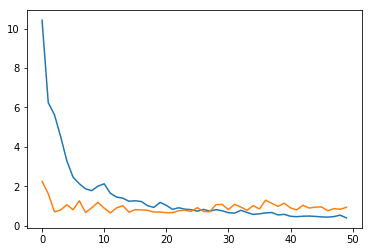

In [461]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss']);

In [462]:
lstm.load_weights('base_model')

In [471]:
num = 379
p = x_train[num]
p = p.reshape(1, 6, output_size)
print('Actual: {} Predicted: {}' .format(y_train[num], lstm.predict(x_train[num:num + 1])))

Actual: 2.6 Predicted: [[2.8350923]]


In [476]:
preds = lstm.predict(x_test)

In [477]:
mse = mean_squared_error(y_test, preds)
print('MSE: {}' .format(mse))
print('RMSE: {}' .format(np.sqrt(mse)))

MSE: 0.639977546818
RMSE: 0.799985966638


In [414]:
unified_mn = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in unified_mn.layers[:7]:
    layer.trainable = False

In [415]:
unified_model = Sequential()
unified_model.add(TimeDistributed(unified_mn, input_shape=(6, 224, 224, 3)))
unified_model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))
unified_model.add(TimeDistributed(MaxPooling2D()))
unified_model.add(TimeDistributed(Flatten()))

In [416]:
unified_model.add(LSTM(128, return_sequences = True))
unified_model.add(LSTM(128, dropout = .2))
unified_model.add(Dense(1))
unified_model.compile(loss='mse', optimizer='adam', metrics = [metrics.mean_squared_error])
unified_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_47 (TimeDis (None, 6, 7, 7, 1024)     3228864   
_________________________________________________________________
time_distributed_48 (TimeDis (None, 6, 3, 3, 1024)     0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 6, 1, 1, 1024)     0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 6, 1024)           0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 6, 128)            590336    
_________________________________________________________________
lstm_52 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 1)               

In [417]:
np.array(tensor_stack).shape

(554, 6, 224, 224, 3)

In [425]:
tensor_stack[0].shape

(6, 224, 224, 3)

In [427]:
t = tensor_stack[0].reshape(1,6,224,224,3)

In [429]:
t_hist = unified_model.fit(t, targets[:1], epochs = 2)

Epoch 1/2
1/1 [==============================] - 26s 26s/step - loss: 209.0516 - mean_squared_error: 209.0516
Epoch 2/2
1/1 [==============================] - 2s 2s/step - loss: 162.6521 - mean_squared_error: 162.6521
